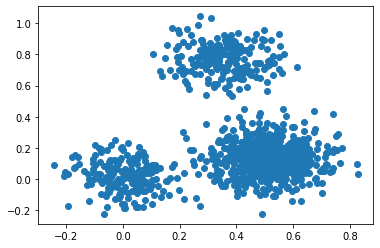

In [19]:
import sklearn as sk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix
from scipy.spatial import distance
from scipy.spatial import KDTree

#for each row, gneerate data which has a gaussian dist with mean of city center
#np.random.rand
#city 
num_cities = 5
dim = 2
cities_locations = np.random.rand(num_cities, dim)
probs = [0.2,0.2,0.2,0.2,0.2]
pop = 1000
X = np.zeros([pop,dim])
norm = -9999
for i in range(pop):
  city = np.random.choice(np.arange(0,5),p=probs)
  center = cities_locations[city,:]
  X[i] = np.random.normal(loc = center,scale = 0.1,size = (1,dim))
  norm =max(norm, np.linalg.norm(X[i],1))
plt.scatter(X[:,0],X[:,1])

DPEM (Wu et Al)

In [20]:
#create a weights, means, and covariance matrix
def prepareGMM(k,X):
  dim = 2 
  #fill the weights with random numbres between 0,1
  weights = np.random.rand(k)
  weights = weights/np.sum(weights)
  means = np.random.rand(k,dim)
  cov = []
  for i in range(k):
    cov.append(make_spd_matrix(X.shape[1]))
  cov = np.array(cov)
  return means, cov, weights

def get_near_psd(A):
    C = (A + A.T)/2
    eigval, eigvec = np.linalg.eig(C)
    eigval[eigval < 0] = 0

    return eigvec.dot(np.diag(eigval)).dot(eigvec.T)


#Need to break the algorithm into the E and M steps
def DPEM(X, k, max_r,eps=1e-8, max_iter=30):
  # 0. Initialize theta = (mu, sigma, pi) and dimension of data
  means, cov, weights = prepareGMM(k,X)

  #Dimension and number of records
  dim =X.shape[1]
  n = X.shape[0]

  #DP parameters
  epsilon = 3.
  delta = .0001
  B = 2
  ew = (.04*B)/max_iter
  em = (.16*B)/(max_iter*k)
  es = (0.7*B)/(max_iter*k)

  for step in range(max_iter):
    
    score = []
    responsibility = []
    # Expectation step, use the built sklearn multivariate normal -> credit to some Towards Data Science article for pointing out a way to do this
    #Essentially, we want to predict the likelihood that each point belongs to one of the means  
    
    # Responsibilities calculation, this is equation 10 in the paper
    for j in range(k):
      score.append(multivariate_normal.pdf(x=X, mean=means[j], cov=cov[j]) *weights[j])

    for j in range(k):
      responsibility.append(score[j] / np.sum(score,axis=0))

    #print(" Checking Maximization step: \n")
    #Maximization step 
    for j in range(k):
      # update mean and variance based on the observation
      # print("Responsibilities are updated to: {}".format(responsibility[j]))
      # print("Means are {}".format(means[j]))
      means[j] = np.sum(responsibility[j].reshape(len(X),1) * X, axis=0) / (np.sum(responsibility[j]))
      # print("Means are updated to: {}".format(means[j]))

      cov[j] = np.dot((responsibility[j].reshape(len(X),1) * (X - means[j])).T, (X - means[j])) / (np.sum(responsibility[j]))
      weights[j] = np.mean(responsibility[j])
    
    #weights calibration
    weights_sens = k/n
    weights = weights + np.random.laplace(loc = 0,scale = (weights_sens)/ew, size = weights.shape)
    weights = np.clip(weights, 0.01, 1000)
    weights = weights/np.sum(weights)

    #means calibration
    for i in range(k):
      # print("Mean {} is {}".format(i,means))
      means_sens = (4*norm*k)/n
      noise =  np.random.laplace(loc = 0,scale = (means_sens)/em, size = means.shape)
      # print("Noise is {}".format(noise))
      # print("Means are {}".format(means[i]))
      temp = means[i] + noise
      if np.all(temp <0):
        temp = np.array([.0001,.0001])
      elif np.all(temp >1):
        temp = np.array([.999,.999])
      elif np.any(temp > 1) or np.any(temp<0):
        ones = np.ones((1,2))

        zeroes = np.zeros((1,2))
        # bottom_right = np.array([1,0])
        # upper_left = np.array([0,1])
        nodes = np.asarray([ones,zeroes])
        dists = []
        for i in range(len(nodes)):
          dists.append(np.linalg.norm(temp-nodes[i]))
        dists = np.array(dists)
        temp = nodes[np.where(dists == np.amin(dists))]  
      else:
        means[i] = temp
      #print("Means are {}".format(means[i]))    
    #covariances calibration
    # cov_sens = (12*n*k*max_r**2 + 8*(k**2)*(max_r**2))/(n**2)
    # for i in range(k):
    #   nse_mat =  np.random.laplace(loc = 0,scale = (cov_sens)/es, size = cov[i].shape)
    #   upper_nse_mat = np.triu(nse_mat, 0)
    #   lower_triangle = np.triu(nse_mat,1)
    #   noise_sum = upper_nse_mat + lower_triangle.transpose()
    #   print("Noise mat is {}".format(noise_sum))
    #   cov[i] = cov[i] + noise_sum

    # #covariances,currently broken
    # for i in range(k):
    #   cov_i = cov[i]
    #   print(np.linalg.eig(cov_i))
    #   w,v = np.linalg.eig(cov_i)
    #   val = max(0,-1*min(w))
    #   print("Additional noise {}".format(np.identity(dim)*val))
    #   print("Covariances are{} ".format(cov[i]))
    #   cov_i = cov_i + np.identity(dim)*val
    #   cov_i = get_near_psd(cov_i)
    #   cov[i] = cov_i

  return weights,means,cov


 Entering GMM


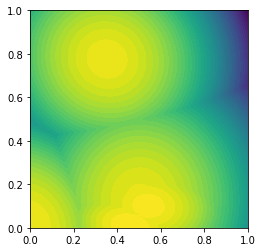

In [21]:
print("\n Entering GMM")
k=5
w3,m3,c3 = DPEM(X,k,norm)

 #make grid resolution on the unit square
lin_param = (0., 1., 100)
x = np.linspace(*lin_param)
y = np.linspace(*lin_param)

xx, yy = np.meshgrid(x, y)
pos = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis = 1)

#evaluate v on a grid by finding the likelhood one point on the grid belongs to the 
likelihood = []

for j in range(len(pos)):
  likelihood.append( [np.log(multivariate_normal.pdf(x=pos[j], mean=m3[t], cov=c3[t])) for t in range(k)] )


#get the probability 
likelihood = np.asarray(likelihood)
np.nan_to_num(likelihood)

probs = []
for l in range(len(likelihood)):
  probs.append(max(likelihood[l]))


probs = np.asarray(probs)
probs = probs.reshape(xx.shape)

plt.contourf(x, y, probs, 50, cmap="viridis")
plt.axis('square')
plt.show()

DPEM (AI-Stats code)

In [28]:
#create a weights, means, and covariance matrix
def prepareGMM(k,X):
  dim = 2 
  #fill the weights with random numbres between 0,1
  weights = np.random.rand(k)
  weights = weights/np.sum(weights)
  means = np.random.rand(k,dim)
  cov = []
  for i in range(k):
    cov.append(make_spd_matrix(X.shape[1]))
  cov = np.array(cov)
  return means, cov, weights



#Need to break the algorithm into the E and M steps
def DPEM(X, k, eps=1e-8, max_iter=100):
  # 0. Initialize theta = (mu, sigma, pi) and dimension of data
  means, cov, weights = prepareGMM(k,X)
  dim =2 

  #DP parameters
  # epsilon = .001
  # delta = 1e-6
  epsilon = 1e-6
  delta = 1e-6
  c2 = 2*np.log(1.25/delta)
  for step in range(max_iter):
    
    score = []
    responsibility = []
    # Expectation step, use the built sklearn multivariate normal -> credit to some Towards Data Science article for pointing out a way to do this
    #Essentially, we want to predict the likelihood that each point belongs to one of the means  
    
    # Responsibilities calculation, this is equation 10 in the paper
    for j in range(k):
      score.append(multivariate_normal.pdf(x=X, mean=means[j], cov=cov[j]) *weights[j])

    for j in range(k):
      responsibility.append(score[j] / np.sum(score,axis=0))

   #print(" Checking Maximization step: \n")
    #Maximization step 
    for j in range(k):
      # update mean and variance based on the observation
      # print("Responsibilities are updated to: {}".format(responsibility[j]))
      # print("Means are {}".format(means[j]))
      means[j] = np.sum(responsibility[j].reshape(len(X),1) * X, axis=0) / (np.sum(responsibility[j]))
      # print("Means are updated to: {}".format(means[j]))

      cov[j] = np.dot((responsibility[j].reshape(len(X),1) * (X - means[j])).T, (X - means[j])) / (np.sum(responsibility[j]))
      weights[j] = np.mean(responsibility[j])
    
    #add privacy to the weights
    weights_sens = 2./X.shape[0]
    nsv = c2*(weights_sens**2)/(epsilon**2)
    nse_mat = np.random.normal(0,scale=np.sqrt(nsv),size = weights.shape)
    weights = weights+nse_mat   
    
    # # #weights fixing:
    # # #here, we sum the weights and check if they are equal to one.
    # # #if they are not, we add the difference to the first element
    # # #this will be fine tuned later.
    # # #if np.any(weights) < 0:
    
    weights = np.clip(weights, 0.01, 1000)
    weights = weights/np.sum(weights)
 
    
    


    # add privacy to the means
    # Note, we have an error where is the mean is outside of the unit square
    # it will throw off the probabilities, need to correct this somehow
    # Currently, it is corrected for by regenerating the noise until the mean in question
    # is within the unit square, seems to trigger an infinite while loop
    # check for l2 norm bounded by 1 later, generate data which (-1/2 to -1/2) square  (unit circle), or censor norms bigger than one make sure
    #Note, Mijung checks if the l2 norm is greater than one and divides by that norm 
    for i in range(k):
      # print("Mean {} is {}".format(i,means))
      means_sens = 2./np.sum(weights[i])
      nsv = c2*(means_sens**2)/(epsilon**2)
      
      noise = np.random.normal(0,np.sqrt(nsv),size = (1,dim))
      # print("Noise is {}".format(noise))
      # print("Means are {}".format(means[i]))
      temp = means[i] + noise
      if np.all(temp <0):
        temp = np.array([.0001,.0001])
      elif np.all(temp >1):
        temp = np.array([.999,.999])
      elif np.any(temp > 1) or np.any(temp<0):
        ones = np.ones((1,2))

        zeroes = np.zeros((1,2))
        # bottom_right = np.array([1,0])
        # upper_left = np.array([0,1])
        nodes = np.asarray([ones,zeroes])
        dists = []
        for i in range(len(nodes)):
          dists.append(np.linalg.norm(temp-nodes[i]))
        dists = np.array(dists)
        temp = nodes[np.where(dists == np.amin(dists))]  
      else:
        means[i] = temp
      #print("Means are {}".format(means[i]))




    #covariances,currently broken
    for i in range(k):
      cov_i = cov[i]
      print("Iter: {}".format(i))
      print("Old covariances are: {}".format(cov[i]))
      cov_sens = 2./np.sum(weights[i])
      print(cov_sens)
      nsv = (c2*(cov_sens**2)/(epsilon**2))
      print(nsv)
      print(weights[i])
      nse_mat = np.random.normal(0,nsv,[dim,dim])
      print("NSE mat is {} \n".format(nse_mat))
      upper_nse_mat = np.triu(nse_mat, 0)
      lower_triangle = np.triu(nse_mat,1)
      upper_nse_mat = upper_nse_mat + lower_triangle.transpose()
      cov_i = cov_i + upper_nse_mat

      w, v = np.linalg.eig(cov_i)
      neg_idx = np.nonzero(w<=0)
      w[neg_idx] = 0.0001
      cov_i = np.dot(v, np.dot(np.diag(w), v.transpose()))
      # print("New covariances are: {}".format(cov_i))
    
      cov[i] = cov_i
      print(cov[i])
      print("End iter:")
    print("\n")
  return weights,means,cov

In [29]:
print("\n Entering GMM")
k=5
w,m,c = DPEM(X,k)



 #make grid resolution on the unit square
lin_param = (0., 1., 100)
x = np.linspace(*lin_param)
y = np.linspace(*lin_param)

xx, yy = np.meshgrid(x, y)
pos = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis = 1)

#evaluate v on a grid by finding the likelhood one point on the grid belongs to the 
likelihood = []

for j in range(len(pos)):
  likelihood.append( [np.log(multivariate_normal.pdf(x=pos[j], mean=m[t], cov=c[t])) for t in range(k)] )


#get the probability 
likelihood = np.asarray(likelihood)
np.nan_to_num(likelihood)

probs = []
for l in range(len(likelihood)):
  probs.append(max(likelihood[l]))


probs = np.asarray(probs)
probs = probs.reshape(xx.shape)

plt.contourf(x, y, probs, 50, cmap="viridis")
plt.axis('square')
plt.show()


 Entering GMM
Iter: 0
Old covariances are: [[0.0526702  0.00813507]
 [0.00813507 0.06388545]]
400005.99999999994
4.492504087059346e+24
4.999925001124984e-06
NSE mat is [[-5.71060333e+22  5.36439865e+24]
 [-3.19999910e+23 -2.99570989e+24]] 

[[2.55082223e+24 1.94610706e+24]
 [1.94610706e+24 1.48474976e+24]]
End iter:
Iter: 1
Old covariances are: [[0.04555769 0.00420972]
 [0.00420972 0.09857121]]
400005.99999999994
4.492504087059346e+24
4.999925001124984e-06
NSE mat is [[ 5.86585233e+24 -1.05296649e+25]
 [-6.93728580e+24  2.98234010e+24]] 

[[ 8.54696291e+24 -7.45643194e+24]
 [-7.45643194e+24  6.50504488e+24]]
End iter:
Iter: 2
Old covariances are: [[0.04892748 0.00500064]
 [0.00500064 0.06747444]]
4.00006
449250408705934.8
0.4999925001124983
NSE mat is [[ 3.18201385e+14  3.70233070e+14]
 [-1.04023110e+15 -6.52959077e+14]] 

[[3.97860726e+14 1.34373962e+14]
 [1.34373962e+14 4.53836245e+13]]
End iter:
Iter: 3
Old covariances are: [[0.04206399 0.0017535 ]
 [0.0017535  0.10598932]]
400005.

LinAlgError: ignored

Scikit Learn GMM (Quality Control)

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
gm = GaussianMixture(n_components=num_cities, random_state=0).fit(X)
#create a grid with some points on it
lin_param = (0., 1., 100)
x = np.linspace(*lin_param)
y = np.linspace(*lin_param)

xx, yy = np.meshgrid(x, y)
pos = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis = 1)



z = gm.score_samples(pos) 
print(z.shape)
z = z.reshape(xx.shape)

plt.contourf(x, y, z, 50, cmap="viridis")
plt.axis('square')
plt.show()

EM from scratch (Quality Control)

In [ ]:
#create a weights, means, and covariance matrix
def prepareGMM(k,X):
  dim = 2 
  #fill the weights with random numbres between 0,1
  weights = np.random.rand(k)
  weights = weights/np.sum(weights)
  #fill the weights with random numbres between 0,1
  means = np.random.rand(k,dim)
  cov = []
  for i in range(k):
    cov.append(make_spd_matrix(X.shape[1]))
  cov = np.array(cov)
  return means, cov, weights


#Need to break the algorithm into the E and M steps
def estimate_gmm_2(X, k, eps=1e-8, max_iter=100):
    # 0. Initialize theta = (mu, sigma, pi)
  means, cov, weights = prepareGMM(k,X)
  for step in range(max_iter):

    likelihood = []
    b = []
    # Expectation step, use the built sklearn multivariate normal -> credit to some Towards Data Science article for pointing out a way to do this
    #Essentially, we want to predict the likelihood that each point belongs to one of the means
    for j in range(k):
      likelihood.append(multivariate_normal.pdf(x=X, mean=means[j], cov=cov[j]))
     

      

    # Maximization step 
    for j in range(k):
      # probabilities that this point belongs to some cluster, note credit here to Thalles Silva for the summation implemenetation and most of the maximization step
      b.append((likelihood[j] * weights[j]) / (np.sum([likelihood[i] * weights[i] for i in range(k)], axis=0)+eps))
      # update mean and variance based on the observation
      means[j] = np.sum(b[j].reshape(len(X),1) * X, axis=0) / (np.sum(b[j]+eps))
      cov[j] = np.dot((b[j].reshape(len(X),1) * (X - means[j])).T, (X - means[j])) / (np.sum(b[j])+eps)
      weights[j] = np.mean(b[j])
      
  return weights,means,cov

In [ ]:
print("Non_Private GMM Call")
w2,m2,c2 = estimate_gmm_2(X,num_cities)


 #make grid resolution on the unit square
lin_param = (0., 1., 100)
x = np.linspace(*lin_param)
y = np.linspace(*lin_param)

xx, yy = np.meshgrid(x, y)
pos = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis = 1)

k=num_cities
#evaluate v on a grid by finding the likelhood one point on the grid belongs to the 
likelihood = []
for j in range(len(pos)):
  likelihood.append( [np.log(multivariate_normal.pdf(x=pos[j], mean=m2[t], cov=c2[t])) for t in range(k)] )

#get the probability 
likelihood = np.asarray(likelihood)


probs = []
for l in range(len(likelihood)):
  probs.append(max(likelihood[l]))

probs2 = np.asarray(likelihood)
probs = np.asarray(probs)
probs = probs.reshape(xx.shape)

plt.contourf(x, y, probs, 50, cmap="viridis")
plt.axis('square')
plt.show()

Print Statements for Debugging

In [ ]:
print("Wu et al means {}".format(m3))
print("Park et al means {}".format(m2))
print("Scikit learn means {}".format(gm.means_))

In [ ]:
print("Wu et al weights {}".format(w3))
print("Park et al weights {}".format(w2))
print("Scikit learn means {}".format(gm.weights_))

In [ ]:
print("Wu et al covariances {}".format(c3))
print("Park et al covariances{}".format(c2))
print("Scikit learn covariances {}".format(gm.covariances_))